# Figure 3.b

In [2]:
import numpy as np
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def payoff(p, q, qvec, delta, piv1, piv2):
    """
    payoff function from previous code - already translated
    """
    eps = 1e-3
    
    p = p * (1 - eps) + (1 - p) * eps
    q = q * (1 - eps) + (1 - q) * eps
    
    # Transforming the reduced strategies into (8+1)-dim strategies
    p = np.concatenate([p[0:4], p[0:4], [p[4]]])
    q = np.concatenate([q[0:4], q[0:4], [q[4]]])
    
    M = np.array([
        [qvec[0]*p[0]*q[0], qvec[0]*p[0]*(1-q[0]), qvec[0]*(1-p[0])*q[0], qvec[0]*(1-p[0])*(1-q[0]), 
         (1-qvec[0])*p[4]*q[4], (1-qvec[0])*p[4]*(1-q[4]), (1-qvec[0])*(1-p[4])*q[4], (1-qvec[0])*(1-p[4])*(1-q[4])],
        [qvec[1]*p[1]*q[2], qvec[1]*p[1]*(1-q[2]), qvec[1]*(1-p[1])*q[2], qvec[1]*(1-p[1])*(1-q[2]), 
         (1-qvec[1])*p[5]*q[6], (1-qvec[1])*p[5]*(1-q[6]), (1-qvec[1])*(1-p[5])*q[6], (1-qvec[1])*(1-p[5])*(1-q[6])],
        [qvec[1]*p[2]*q[1], qvec[1]*p[2]*(1-q[1]), qvec[1]*(1-p[2])*q[1], qvec[1]*(1-p[2])*(1-q[1]), 
         (1-qvec[1])*p[6]*q[5], (1-qvec[1])*p[6]*(1-q[5]), (1-qvec[1])*(1-p[6])*q[5], (1-qvec[1])*(1-p[6])*(1-q[5])],
        [qvec[2]*p[3]*q[3], qvec[2]*p[3]*(1-q[3]), qvec[2]*(1-p[3])*q[3], qvec[2]*(1-p[3])*(1-q[3]), 
         (1-qvec[2])*p[7]*q[7], (1-qvec[2])*p[7]*(1-q[7]), (1-qvec[2])*(1-p[7])*q[7], (1-qvec[2])*(1-p[7])*(1-q[7])],
        [qvec[3]*p[0]*q[0], qvec[3]*p[0]*(1-q[0]), qvec[3]*(1-p[0])*q[0], qvec[3]*(1-p[0])*(1-q[0]), 
         (1-qvec[3])*p[4]*q[4], (1-qvec[3])*p[4]*(1-q[4]), (1-qvec[3])*(1-p[4])*q[4], (1-qvec[3])*(1-p[4])*(1-q[4])],
        [qvec[4]*p[1]*q[2], qvec[4]*p[1]*(1-q[2]), qvec[4]*(1-p[1])*q[2], qvec[4]*(1-p[1])*(1-q[2]), 
         (1-qvec[4])*p[5]*q[6], (1-qvec[4])*p[5]*(1-q[6]), (1-qvec[4])*(1-p[5])*q[6], (1-qvec[4])*(1-p[5])*(1-q[6])],
        [qvec[4]*p[2]*q[1], qvec[4]*p[2]*(1-q[1]), qvec[4]*(1-p[2])*q[1], qvec[4]*(1-p[2])*(1-q[1]), 
         (1-qvec[4])*p[6]*q[5], (1-qvec[4])*p[6]*(1-q[5]), (1-qvec[4])*(1-p[6])*q[5], (1-qvec[4])*(1-p[6])*(1-q[5])],
        [qvec[5]*p[3]*q[3], qvec[5]*p[3]*(1-q[3]), qvec[5]*(1-p[3])*q[3], qvec[5]*(1-p[3])*(1-q[3]), 
         (1-qvec[5])*p[7]*q[7], (1-qvec[5])*p[7]*(1-q[7]), (1-qvec[5])*(1-p[7])*q[7], (1-qvec[5])*(1-p[7])*(1-q[7])]
    ])
    
    # Expected outcome for first round
    v0 = np.array([p[8]*q[8], p[8]*(1-q[8]), (1-p[8])*q[8], (1-p[8])*(1-q[8]), 0, 0, 0, 0])
    
    # Calculating the weighted average frequency to observe each outcome
    v = (1 - delta) * v0 @ np.linalg.inv(np.eye(8) - delta * M)
    v = v / np.sum(v)
    
    pi1 = np.dot(piv1, v)
    pi2 = np.dot(piv2, v)
    
    s1 = np.sum(v[0:4])
    cop1 = (v[0] + v[1]) / s1
    cop2 = (v[0] + v[2]) / s1 
    
    return pi1, pi2, cop1, cop2, s1

In [4]:
def CalcRho(S1, S2, PayM, N, beta):
    """
    Parameters:
    -----------
    S1, S2 : int
        Strategy indices
    PayM : numpy array
        Payoff matrix
    N : int
        Population size
    beta : float
        Selection strength
    
    Returns:
    --------
    Rho : float
        Fixation probability
    """
    alpha = np.zeros(N - 1)
    
    for j in range(1, N):  # j: Number of mutants in population (1 to N-1)
        # Payoff mutant
        # MATLAB: pi1=(j-1)/(N-1)*PayM(S1,S1)+(N-j)/(N-1)*PayM(S1,S2)
        pi1 = ((j - 1) / (N - 1)) * PayM[S1, S1] + ((N - j) / (N - 1)) * PayM[S1, S2]
        
        # Payoff resident
        # MATLAB: pi2=j/(N-1)*PayM(S2,S1)+(N-j-1)/(N-1)*PayM(S2,S2)
        pi2 = (j / (N - 1)) * PayM[S2, S1] + ((N - j - 1) / (N - 1)) * PayM[S2, S2]
        
        alpha[j-1] = np.exp(-beta * (pi1 - pi2))
    
    # Calculate fixation probability
    # MATLAB: Rho=1/(1+sum(cumprod(alpha)))
    cumprod_alpha = np.cumprod(alpha)
    Rho = 1 / (1 + np.sum(cumprod_alpha))
    
    return Rho

In [5]:
def CalcSMEquilibrium(qvec, piRound, beta, delta):
    """    
    Parameters:
    -----------
    qvec : numpy array (length 6)
        [q12, q11, q10, q02, q01, q00] transition probabilities
    piRound : numpy array (length 8)
        [u1CC, u1CD, u1DC, u1DD, u2CC, u2CD, u2DC, u2DD] payoffs
    beta : float
        Selection strength
    
    Returns:
    --------
    coop : float
        Average cooperation rate
    pay : float
        Average payoff
    s1 : float
        Frequency in state 1
    freq : numpy array
        Frequencies of all memory-1 strategies
    Str : numpy array
        All possible strategies (5-bit)
    """
    # Setting up all objects
    N = 100  # Population size
    
    # Payoff vectors
    pv1 = piRound.copy()  # payoff vector from perspective of player 1
    
    # Creating payoff vector from perspective of player 2
    # MATLAB: pv2(2:3)=piRound(3:-1:2); pv2(6:7)=piRound(7:-1:6)
    pv2 = piRound.copy()
    pv2[1:3] = piRound[2:0:-1]  # Swap positions 1 and 2
    pv2[5:7] = piRound[6:4:-1]  # Swap positions 5 and 6
    
    # List of all memory-1 strategies (5-bit binary)
    n_strategies = 2**5
    Str = np.zeros((n_strategies, 5), dtype=int)
    
    for i in range(n_strategies):
        bin_str = format(i, f'0{5}b')
        Str[i] = list(map(int, bin_str))
    
    # Convert 5-dim strategy vectors to 8-dim vectors using Proposition 1
    # MATLAB: Str8=[Str(:,1)'; Str(:,3)'; Str(:,4)'; Str(:,5)'; Str(:,2)'; Str(:,3)'; Str(:,4)'; Str(:,5)']'
    Str8 = np.zeros((n_strategies, 8))
    Str8[:, 0] = Str[:, 0]  # pC|CC
    Str8[:, 1] = Str[:, 2]  # pC|CD
    Str8[:, 2] = Str[:, 3]  # pC|DC
    Str8[:, 3] = Str[:, 4]  # pC|DD
    Str8[:, 4] = Str[:, 1]  # pD|CC
    Str8[:, 5] = Str[:, 2]  # pD|CD
    Str8[:, 6] = Str[:, 3]  # pD|DC
    Str8[:, 7] = Str[:, 4]  # pD|DD
    
    # Initialize matrices
    PayM = np.zeros((n_strategies, n_strategies))
    C = np.zeros((n_strategies, n_strategies))  # Cooperation matrix
    S1_mat = np.zeros((n_strategies, n_strategies))  # State 1 frequency matrix
    
    # Calculate all pairwise quantities
    #print("Calculating pairwise payoffs...")
    for i in range(n_strategies):
        for j in range(i, n_strategies):
            pi1, pi2, cop1, cop2, s1_val = payoff(Str8[i], Str8[j], qvec,delta, pv1, pv2)

            PayM[i, j] = pi1
            PayM[j, i] = pi2
            
            C[i, j] = cop1
            C[j, i] = cop2
            
            S1_mat[i, j] = s1_val
            S1_mat[j, i] = s1_val  # Assuming symmetric for state frequency
    
    # Setting up the transition matrix according to Fudenberg and Imhof
    T = np.zeros((n_strategies, n_strategies))
    
    #print("Calculating transition matrix...")
    for i in range(n_strategies):
        # Calculate off-diagonal entries
        for j in range(n_strategies):
            if i != j:
                # Off-diagonal: (1/(n_strategies-1)) * fixation probability
                T[i, j] = (1 / (n_strategies - 1)) * CalcRho(j, i, PayM, N, beta)
        
        # Diagonal: 1 - sum of off-diagonal entries
        # MATLAB: T(i,i)=0; T(i,i)=1-sum(T(i,:))
        row_sum = np.sum(T[i, :])
        T[i, i] = 1 - row_sum
    
    
    # Calculate invariant distribution (stationary distribution)
    # MATLAB: v=null(T'-eye(2^5)); freq=v'/sum(v)
    #print("Calculating stationary distribution...")
    v = null_space(T.T - np.eye(n_strategies))
    if v.size == 0:
        raise ValueError("Null space is empty")
    
    v = v / np.sum(v)
    v = v.flatten()
    freq = v
    
    # Calculate equilibrium quantities
    # MATLAB: coop=freq*diag(C)
    coop = np.sum(freq * np.diag(C))
    
    # MATLAB: pay=freq*diag(PayM)
    pay = np.sum(freq * np.diag(PayM))
    
    return coop, pay, freq, Str

In [6]:
def GetEvolData():
    """
    Creates data for Figure 3b
    """
    beta = 1
    b = 2
    c = 1
    delta = 0.999
    
    # List of q-values: 10.^(-5:0.02:0)
    # This creates log-spaced values from 10^-5 to 10^0 = 1
    qPoss = 10 ** np.arange(-5, 0.02, 0.02)
    n = len(qPoss)
    
    piRound = np.array([b - c, -c, b, 0, 0, 0, 0, 0])
    coop = np.zeros(n)
    pay = np.zeros(n)
    
    Data = f"b={b}; c={c}; beta={beta}; delta={delta}"
    
    for i in tqdm(range(n)):
        q = qPoss[i]
        qvec = np.array([1, 1 - q, 1 - q, 0, 0, 0])
        coop[i], pay[i], _, _ = CalcSMEquilibrium(qvec, piRound, beta, delta)
    
    return qPoss, coop, pay, Data

## Run the calculation


In [7]:
print("Calculating Figure 3b data...")
qPoss, coop, pay, Data = GetEvolData()

print(f"\nParameters: {Data}")
print(f"Number of q values: {len(qPoss)}")
print(f"q range: {qPoss[0]:.2e} to {qPoss[-1]:.2f}")

Calculating Figure 3b data...


100%|██████████| 251/251 [03:21<00:00,  1.25it/s]


Parameters: b=2; c=1; beta=1; delta=0.999
Number of q values: 251
q range: 1.00e-05 to 1.00


 ## Plotting

Saved: figure_3b.pdf


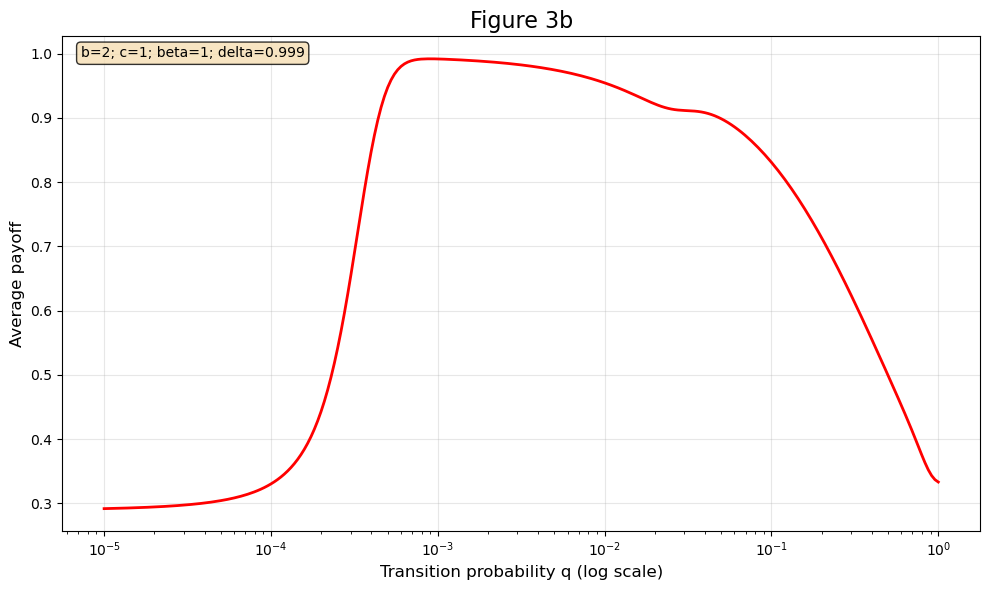

In [8]:
def save_figure(filename, formats=['pdf'], **kwargs):
    """
    Save current figure in multiple formats.
    
    Parameters:
    - filename: Base filename without extension
    - formats: List of formats ['pdf', 'png', 'svg', 'jpg', etc.]
    - **kwargs: Additional kwargs for plt.savefig()
    """
    for fmt in formats:
        full_name = f"{filename}.{fmt}"
        plt.savefig(full_name, format=fmt, bbox_inches='tight', **kwargs)
        print(f"Saved: {full_name}")

fig, ax = plt.subplots(figsize=(10, 6))

ax.semilogx(qPoss, pay, 'r-', linewidth=2)
ax.set_xlabel('Transition probability q (log scale)', fontsize=12)
ax.set_ylabel('Average payoff', fontsize=12)
ax.set_title('Payoff in Selection-Mutation Equilibrium', fontsize=14)
ax.grid(True, alpha=0.3)

# Add parameter information
ax.text(0.02, 0.98, Data, transform=ax.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.title("Figure 3b", fontsize=16)
plt.tight_layout()
save_figure('figure_3b', formats=['pdf'], dpi=300)
plt.show()